# Direct ERT to Water Content Conversion: Three Scenarios

This notebook demonstrates PyHydroGeophysX's natural language agent capabilities through three progressively detailed scenarios:

1. **Scenario 1 - Simple Natural Language**: Basic request with minimal details
2. **Scenario 2 - Geology-Informed**: Including site description and geological context for parameter estimation
3. **Scenario 3 - Fully Specified**: Detailed petrophysical parameters from field measurements

Each scenario shows how the agents interpret natural language and automatically configure the workflow.

## Setup and Configuration

First, we'll set up the workspace, import required libraries, and initialize the agents.

In [1]:
import os
import sys
import json
from pathlib import Path
from typing import Dict, Any

import numpy as np

# Setup workspace paths
workspace_root = Path.cwd()
if str(workspace_root) not in sys.path:
    sys.path.insert(0, str(workspace_root))

# Navigate to project root if currently in examples directory
if workspace_root.name == 'examples':
    workspace_root = workspace_root.parent

# Results directory - save in examples/results/direct_ert_conversion
results_root = (workspace_root / 'examples' / 'results' / 'direct_ert_conversion').resolve()
results_root.mkdir(parents=True, exist_ok=True)

print(f'Workspace root: {workspace_root}')
print(f'Results directory: {results_root}')


Workspace root: c:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX
Results directory: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion


In [ ]:
# Configure LLM API
llm_provider = 'openai'
llm_model = 'gpt-4o-mini'#'gpt-4o-mini'

provider_env_map = {
    'openai': 'OPENAI_API_KEY',
    'gemini': 'GEMINI_API_KEY',
    'claude': 'ANTHROPIC_API_KEY'
}

env_var = provider_env_map.get(llm_provider, '')
api_key = os.environ.get(env_var, '')

if api_key:
    print(f'✓ API key detected for {llm_provider}; using model {llm_model}.')
else:
    print('⚠ No API key detected; agents will use default parameters without NLP parsing.')

✓ API key detected for openai; using model gpt-4o-mini.


In [3]:
# Initialize agents (with module reload to pick up latest changes)
import importlib
import sys

# Remove cached modules
modules_to_reload = [m for m in sys.modules.keys() if m.startswith('PyHydroGeophysX.agents')]
for m in modules_to_reload:
    del sys.modules[m]

from PyHydroGeophysX.agents import (
    ContextInputAgent,
    ERTInversionAgent,
    InversionEvaluationAgent,
    PetrophysicsAgent,
    ReportAgent
)

context_agent = ContextInputAgent(api_key=api_key, model=llm_model, llm_provider=llm_provider)
ert_inversion_agent = ERTInversionAgent(api_key=api_key, model=llm_model, llm_provider=llm_provider)
evaluation_agent = InversionEvaluationAgent(api_key=api_key, model=llm_model, llm_provider=llm_provider)
petro_agent = PetrophysicsAgent(api_key=api_key, model=llm_model, llm_provider=llm_provider)
report_agent = ReportAgent(api_key=api_key, model=llm_model, llm_provider=llm_provider)

print('✓ All agents initialized successfully (with module reload).')

API path =  c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\resipy
ResIPy version =  3.6.3
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.
API path =  c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\resipy
ResIPy version =  3.6.3
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.
✓ All agents initialized successfully (with module reload).
✓ All agents initialized successfully (with module reload).


---

## Scenario 1: Simple Natural Language Request

**User Request**: *"We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data and electrode file in examples/data/ERT/DAS/electrodes.dat and help me invert and convert to water content"*

This scenario demonstrates a basic workflow where the user provides:
- Data file location
- Electrode coordinate file
- Instrument type
- Basic task description

The agents will:
- Parse data file and electrode file paths from natural language
- Use default inversion parameters
- Apply generic petrophysical models
- Provide basic uncertainty estimates

In [4]:
# Scenario 1: Parse natural language request
user_request_1 = "We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data and electrode file in examples/data/ERT/DAS/electrodes.dat and help me invert and convert to water content"

print(f"User request: '{user_request_1}'")
print("\nParsing request with ContextInputAgent...")

# Let the agent parse the natural language request
workflow_config_1 = context_agent.parse_request(user_request_1)

# Debug: Print what the agent extracted
print("\n[DEBUG] Raw parsed configuration from agent:")
print(json.dumps(workflow_config_1, indent=2, default=str))

# Extract data file path from parsed configuration
data_file_rel = workflow_config_1.get('data_file', 'examples/data/ERT/DAS/20171105_1418.Data')
data_file_1 = (workspace_root / data_file_rel).resolve()
project_dir_1 = data_file_1.parent

# Extract electrode file path from parsed configuration
electrode_file_rel = workflow_config_1.get('electrode_file', 'examples/data/ERT/DAS/electrodes.dat')
electrode_file_1 = (workspace_root / electrode_file_rel).resolve()

# Verify files exist
if not data_file_1.exists():
    raise FileNotFoundError(f'Data file not found: {data_file_1}')
if not electrode_file_1.exists():
    raise FileNotFoundError(f'Electrode file not found: {electrode_file_1}')

# Update configuration with resolved paths
workflow_config_1['data_file'] = str(data_file_1)
workflow_config_1['electrode_file'] = str(electrode_file_1)
workflow_config_1['project_dir'] = str(project_dir_1)

print(f"\nExtracted data file: {data_file_1}")
print(f"Extracted electrode file: {electrode_file_1}")


User request: 'We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data and electrode file in examples/data/ERT/DAS/electrodes.dat and help me invert and convert to water content'

Parsing request with ContextInputAgent...

[DEBUG] Raw parsed configuration from agent:
{
  "inversion_parameters": {
    "lambda": 20.0,
    "max_iterations": 10,
    "method": "cgls",
    "use_gpu": false
  },
  "petrophysical_parameters": {},
  "instrument": "DAS-1",
  "data_file": "examples/data/ERT/DAS/20171105_1418.Data",
  "electrode_file": "examples/data/ERT/DAS/electrodes.dat",
  "project_dir": "examples/data/ERT/DAS",
  "crs": "local",
  "inversion_mode": "standard",
  "inversion_params": {
    "lambda": 20.0,
    "max_iterations": 10,
    "method": "cgls",
    "use_gpu": false
  },
  "use_climate": false,
  "use_seismic": false,
  "run_uncertainty": true,
  "n_realizations": 100,
  "petrophysical_params": {}
}

Extracted data file: C:\Users\hchen117\OneDrive - University 

In [5]:
# Scenario 1: Load ERT data and run automatic inversion workflow
from PyHydroGeophysX.data_processing.ert_data_agent import load_ert_resipy

scenario_1_dir = results_root / 'scenario_1_simple'
scenario_1_dir.mkdir(parents=True, exist_ok=True)

# Extract instrument type and electrode file from natural language parsing
instrument_type = workflow_config_1.get('instrument')
electrode_file = workflow_config_1.get('electrode_file')

print(f"Loading ERT data from {data_file_1}")
print(f"  Using instrument type: {instrument_type}")
print(f"  Using electrode file: {electrode_file}")

ert_data_1 = load_ert_resipy(
    project_dir=str(project_dir_1),
    data_file=str(data_file_1),
    instrument=instrument_type,
    electrode_file=str(electrode_file) if electrode_file else None,
    spacing=None  # Electrode positions loaded from file
)
print(f"✓ Loaded {len(ert_data_1.observations)} measurements from {len(ert_data_1.electrodes)} electrodes")
print(f"✓ All measurements have k=1 (geometric factors computed during inversion)")

inversion_input_1 = {
    'ert_data': ert_data_1,
    'instrument': instrument_type,
    'project_dir': str(project_dir_1),
    'output_dir': str(scenario_1_dir / 'inversion'),
    'inversion_params': {
        'lambda': 20.0,
        'max_iterations': 12,
        'method': 'cgls'
    }
}

print("Running automatic ERT inversion workflow...")
inversion_results_1 = ert_inversion_agent.execute(inversion_input_1)

if inversion_results_1.get('status') != 'success':
    raise RuntimeError(inversion_results_1.get('error', 'Inversion failed'))

print(f"✓ Inversion complete: chi² = {inversion_results_1.get('chi2'):.3f}, iterations = {inversion_results_1.get('iterations')}")


Loading ERT data from C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\20171105_1418.Data
  Using instrument type: DAS-1
  Using electrode file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\electrodes.dat
Working directory is: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS
Working directory is: C:\Users\hchen117\AppData\Local\Temp\resipy_jx8nets9
filterData: 0 / 945 quadrupoles removed.
930/945 reciprocal measurements found.
0 measurements error > 20 %
   Loaded 945 raw resistance measurements from DAS-1
   Updated electrode positions from electrodes.dat
   After basic QC filters: 945 measurements
   Applied reciprocal error filter (< 5%): removed 15 measurements
   Total filtered with DAS quality thresholds: 15 measurements
   After all QC filters: 930 measurements
✓ Loaded 930 measurements from 56 electrodes
✓ All meas

C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\data_processing\ert_data_agent.py:173: UserWarning: RESIPY cannot prepare project directory 'C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS' (PermissionError). Falling back to a temporary project directory.
  warnings.warn(
07/11/25 - 17:42:53 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 127): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:42:53 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:42:53 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:42:53 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:42:53 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:42:53 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/2

   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_1_simple\inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_1_simple\inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=20.0, max_iter=12, method=cgls
[ert_inversion] [INFO] Running ERT inversion...


07/11/25 - 17:42:53 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3632 Cells: 6940 Boundaries: 5366


-------------------Iteration: 0 ---------------------------
chi2: [[120.32985315]]
dPhi: 1.0
chi2: [[120.32985315]]
dPhi: 1.0


C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha = float(gamma / xp.dot(q.T, q))
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma_new = float(xp.dot(s.T, s))
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:230: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error

-------------------Iteration: 1 ---------------------------
chi2: [[14.93102181]]
dPhi: [[0.8759159]]
chi2: [[14.93102181]]
dPhi: [[0.8759159]]
-------------------Iteration: 2 ---------------------------
-------------------Iteration: 2 ---------------------------
chi2: [[5.29795662]]
dPhi: [[0.6451712]]
chi2: [[5.29795662]]
dPhi: [[0.6451712]]
-------------------Iteration: 3 ---------------------------
-------------------Iteration: 3 ---------------------------
chi2: [[2.1358757]]
dPhi: [[0.59684915]]
chi2: [[2.1358757]]
dPhi: [[0.59684915]]
-------------------Iteration: 4 ---------------------------
-------------------Iteration: 4 ---------------------------
chi2: [[0.81629263]]
dPhi: [[0.61781829]]
chi2: [[0.81629263]]
dPhi: [[0.61781829]]
End of inversion
[ert_inversion] [INFO] Inversion completed successfully
[ert_inversion] [INFO] Generating interpretation of results
End of inversion
[ert_inversion] [INFO] Inversion completed successfully
[ert_inversion] [INFO] Generating interpre

C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_chi2 = float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else 0.0


[ert_inversion] [INFO] Final chi2: 0.816, Iterations: 5
✓ Inversion complete: chi² = 0.816, iterations = 5


C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'chi2': float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else None,
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_chi2 = float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else 0.0


In [6]:
# Scenario 1: Evaluate inversion quality
evaluation_input_1 = {
    'inversion_results': inversion_results_1,
    'ert_data': ert_data_1,
    'quality_threshold': 0.7
}

print("Evaluating inversion quality...")
evaluation_results_1 = evaluation_agent.execute(evaluation_input_1)

if evaluation_results_1.get('status') == 'success':
    quality_score = evaluation_results_1.get('quality_score', 0)
    print(f"✓ Quality score: {quality_score:.2f}")
    print(f"  Recommendations: {evaluation_results_1.get('recommendations', 'None')}")
else:
    print("⚠ Evaluation completed with warnings")


07/11/25 - 17:43:07 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 128): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:43:08 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:08 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:08 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:08 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/11/25 - 17:43:08 - pyGIMLi - INFO -

Evaluating inversion quality...
[inversion_evaluation] Starting inversion quality evaluation
[inversion_evaluation] Initial quality score: 50.0/100
[inversion_evaluation] Attempt 2/5: Adjusting parameters
[inversion_evaluation] Fine-tuning: adjusting lambda to 24.00
[inversion_evaluation] Adjusted lambda: 20 → 24.0
[ert_inversion] [INFO] Starting standard ERT inversion
[ert_inversion] [INFO] Exporting data to inversion format
   Exported data with k=1 to results\ert_inversion\bert_data.dat
   Recomputing geometric factors with PyGIMLi...
   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=24.0, max_iter=10, method=cgls
[ert_inversion] [INFO] Running ERT inversion...
-------------------Iteration: 0 ---------------------------
--

07/11/25 - 17:43:21 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 129): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:43:21 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:21 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:21 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:21 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:21 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:21 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:21 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:21 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:43:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/11/25 - 17:43:21 - pyGIMLi - INFO -

[ert_inversion] [INFO] Final chi2: 0.627, Iterations: 5
[inversion_evaluation] New quality score: 50.0/100
[inversion_evaluation] Attempt 3/5: Adjusting parameters
[inversion_evaluation] Fine-tuning: adjusting lambda to 28.80
[inversion_evaluation] Adjusted lambda: 24.0 → 28.799999999999997
[ert_inversion] [INFO] Starting standard ERT inversion
[ert_inversion] [INFO] Exporting data to inversion format
   Exported data with k=1 to results\ert_inversion\bert_data.dat
   Recomputing geometric factors with PyGIMLi...
   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=28.799999999999997, max_iter=10, method=cgls
[ert_inversion] [INFO] Running ERT inversion...
-------------------Iteration: 0 ---------------------------
-------------

In [7]:
# Scenario 1: Automatic petrophysical conversion with agent-determined parameters
mesh_1 = inversion_results_1['mesh']
cell_markers_1 = np.array(mesh_1.cellMarkers())

# Let the agent automatically determine parameters based on context
petro_input_1 = {
    'resistivity_model': inversion_results_1['resistivity_model'],
    'mesh': mesh_1,
    'cell_markers': cell_markers_1,
    'geological_context': 'generic subsurface materials',  # Minimal context
    'n_realizations': 200,
    'output_dir': str(scenario_1_dir / 'petrophysics')
}

print("Running automatic petrophysical conversion...")
print("Agent will determine appropriate parameters based on minimal context...")
petro_results_1 = petro_agent.execute(petro_input_1)

if petro_results_1.get('status') != 'success':
    raise RuntimeError(petro_results_1.get('error', 'Petrophysics conversion failed'))

water_content_1 = petro_results_1['water_content_mean']
water_content_std_1 = petro_results_1['water_content_std']
layer_params_1 = petro_results_1.get('layer_params_used', {})  # Get parameters used by agent

print(f"\n✓ Water content conversion complete")
print(f"  Mean water content: {np.nanmean(water_content_1):.3f} ± {np.nanmean(water_content_std_1):.3f}")
print(f"  Range: [{np.nanmin(water_content_1):.3f}, {np.nanmax(water_content_1):.3f}]")
print(f"\nAgent-determined parameters:")
for marker, params in layer_params_1.items():
    print(f"  Marker {marker}: m={params.get('m', {}).get('mean', 'N/A'):.2f}, n={params.get('n', {}).get('mean', 'N/A'):.2f}, φ={params.get('porosity', {}).get('mean', 'N/A'):.2f}")

Running automatic petrophysical conversion...
Agent will determine appropriate parameters based on minimal context...
[petrophysics] [INFO] Starting petrophysical conversion with uncertainty analysis
[petrophysics] [INFO] Processing 1173 cells, 1 time step(s)
[petrophysics] [INFO] Monte Carlo realizations: 200
[petrophysics] [INFO] Too many unique markers (1173), treating as single layer
[petrophysics] [INFO] Created single-layer model
[petrophysics] [INFO] Found 1 geological layers: [0]
[petrophysics] [INFO] Petrophysical params provided: False
[petrophysics] [INFO] Information level: low
[petrophysics] [INFO] Generating layer parameters based on available information
[petrophysics] [INFO] Generated parameters with low information level (std scale: 75%)
[petrophysics] [INFO] Starting Monte Carlo simulation...


MC Realizations:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\petrophysics\resistivity_models.py:154: RuntimeWarning: divide by zero encountered in divide
  S0 = np.clip((rhos / resistivity)**(1.0 / n_arr), 1e-3, 1.0)
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\petrophysics\resistivity_models.py:164: RuntimeWarning: divide by zero encountered in scalar power
  def f(S):      return A * S**ni + B * S**(ni-1) - Ci
MC Realizations:   6%|▌         | 11/200 [00:00<00:01, 99.50it/s]C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\petrophysics\resistivity_models.py:154: RuntimeWarning: divide by zero encountered in divide
  S0 = np.clip((rhos / resistivity)**(1.0 / n_arr), 1e-3, 1.0)
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\petrophysics\resistivity_

[petrophysics] [INFO] Monte Carlo simulation completed
[petrophysics] [INFO] Results saved to disk
[petrophysics] [INFO] Generating interpretation of petrophysical results
[petrophysics] [INFO] Water content range: 0.0169 - 0.1101
[petrophysics] [INFO] Mean uncertainty: 0.0704

✓ Water content conversion complete
  Mean water content: 0.056 ± 0.070
  Range: [0.017, 0.110]

Agent-determined parameters:
[petrophysics] [INFO] Water content range: 0.0169 - 0.1101
[petrophysics] [INFO] Mean uncertainty: 0.0704

✓ Water content conversion complete
  Mean water content: 0.056 ± 0.070
  Range: [0.017, 0.110]

Agent-determined parameters:


### Scenario 1 Report

**Summary:**
- Used generic petrophysical parameters with high uncertainty
- Suitable for preliminary assessment without site-specific information
- Higher uncertainty in water content estimates due to parameter variability

Generating comprehensive report with ReportAgent...
[report_generator] [INFO] Starting report generation
[report_generator] [INFO] Generating report sections


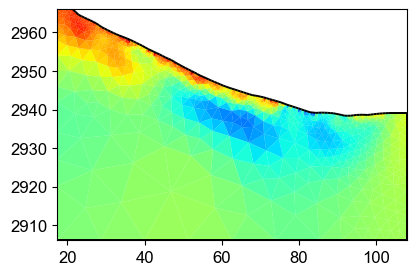

c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\viewer\mpl\colorbar.py:321: UserWarning: Adding colorbar to a different Figure <Figure size 800x300 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = cbarTarget.colorbar(gci, cax=cax, orientation=orientation)


[report_generator] [INFO] Saved resistivity model plot
[report_generator] [INFO] Saved water content plot
[report_generator] [INFO] Saved water content uncertainty plot
[report_generator] [INFO] Generating narrative report with LLM
[report_generator] [INFO] Saved water content uncertainty plot
[report_generator] [INFO] Generating narrative report with LLM
[report_generator] [INFO] Report saved to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_1_simple\report\workflow_report.md
[report_generator] [INFO] PDF report saved to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_1_simple\report\workflow_report.pdf

✓ Report generated successfully
  Markdown: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_1_simple\report\workflow_report.md
  PDF: C:\Users\

<Figure size 640x480 with 0 Axes>

In [8]:
# Scenario 1: Generate detailed report using ReportAgent
print("Generating comprehensive report with ReportAgent...")

# Prepare workflow data for report generation
workflow_data_1 = {
    'ert_data': {
        'n_electrodes': len(ert_data_1.electrodes),
        'n_measurements': len(ert_data_1.observations),
        'instrument': instrument_type
    },
    'inversion_results': {
        'chi2': inversion_results_1.get('chi2'),
        'iterations': inversion_results_1.get('iterations'),
        'resistivity_model': inversion_results_1.get('resistivity_model'),
        'mesh': inversion_results_1.get('mesh'),
        'coverage': inversion_results_1.get('coverage')
    },
    'evaluation_results': {
        'quality_score': evaluation_results_1.get('quality_score')
    },
    'water_content': {
        'mesh': mesh_1,
        'water_content_mean': water_content_1,
        'water_content_std': water_content_std_1,
        'layer_params_used': layer_params_1,
        'n_realizations': 200
    }
}

# Add user_request to config for report
workflow_config_1['user_request'] = user_request_1

report_input_1 = {
    'workflow_data': workflow_data_1,
    'config': workflow_config_1,
    'output_dir': str(scenario_1_dir / 'report')
}

report_results_1 = report_agent.execute(report_input_1)

if report_results_1.get('status') == 'success':
    print(f"\n✓ Report generated successfully")
    print(f"  Markdown: {report_results_1['report_file']}")
    if report_results_1.get('html_file'):
        print(f"  HTML: {report_results_1['html_file']}")
    if report_results_1.get('pdf_file'):
        print(f"  PDF: {report_results_1['pdf_file']}")
    print(f"\n{report_results_1.get('executive_summary', '')}")
else:
    print(f"⚠ Report generation failed: {report_results_1.get('error', 'Unknown error')}")

---

## Scenario 2: Geology-Informed Request

**User Request**: *"We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data and electrode file in examples/data/ERT/DAS/electrodes.dat in the Snowy Range in southeastern Wyoming. The bedrock consists of foliated gneiss in the Cheyenne Belt. The subsurface contains organic soil, coarse angular gravel and cobbles, and a mix of gravel and silt. Guess the petrophysical parameters from geologic description."*

This scenario demonstrates how the agents can:
- Parse data file, electrode file, and instrument type from natural language
- Extract geological context automatically
- Estimate petrophysical parameters based on lithology descriptions

In [9]:
# Scenario 2: Parse geology-informed request
user_request_2 = """We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data 
and electrode file in examples/data/ERT/DAS/electrodes.dat 
in the Snowy Range in southeastern Wyoming. The bedrock consists of foliated gneiss in the Cheyenne Belt. 
The subsurface contains organic soil, coarse angular gravel and cobbles, and a mix of gravel and silt. 
Guess the petrophysical parameters from geologic description."""

print(f"User request: '{user_request_2}'")
print("\nParsing geological context with ContextInputAgent...")

# Let the agent parse the natural language request
workflow_config_2 = context_agent.parse_request(user_request_2)

# Extract data file path from parsed configuration
data_file_rel = workflow_config_2.get('data_file', 'examples/data/ERT/DAS/20171105_1418.Data')
data_file_2 = (workspace_root / data_file_rel).resolve()
project_dir_2 = data_file_2.parent

# Extract electrode file path from parsed configuration
electrode_file_rel = workflow_config_2.get('electrode_file', 'examples/data/ERT/DAS/electrodes.dat')
electrode_file_2 = (workspace_root / electrode_file_rel).resolve()

# Verify files exist
if not data_file_2.exists():
    raise FileNotFoundError(f'Data file not found: {data_file_2}')
if not electrode_file_2.exists():
    raise FileNotFoundError(f'Electrode file not found: {electrode_file_2}')

# Update configuration with resolved paths
workflow_config_2['data_file'] = str(data_file_2)
workflow_config_2['electrode_file'] = str(electrode_file_2)
workflow_config_2['project_dir'] = str(project_dir_2)

print(f"\nExtracted data file: {data_file_2}")
print(f"Extracted electrode file: {electrode_file_2}")
print("\nParsed workflow configuration:")
print(json.dumps(workflow_config_2, indent=2, default=str))


User request: 'We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data 
and electrode file in examples/data/ERT/DAS/electrodes.dat 
in the Snowy Range in southeastern Wyoming. The bedrock consists of foliated gneiss in the Cheyenne Belt. 
The subsurface contains organic soil, coarse angular gravel and cobbles, and a mix of gravel and silt. 
Guess the petrophysical parameters from geologic description.'

Parsing geological context with ContextInputAgent...

Extracted data file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\20171105_1418.Data
Extracted electrode file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\electrodes.dat

Parsed workflow configuration:
{
  "inversion_params": {
    "lambda": 20.0,
    "max_iterations": 10,
    "method": "cgls",
    "use_gpu": false
  },
  "petrophysical_params": {},
  "instrument": "DAS-1",
  "data_file": "C:

In [10]:
# Scenario 2: Load ERT data and run automatic inversion workflow
scenario_2_dir = results_root / 'scenario_2_geology_informed'
scenario_2_dir.mkdir(parents=True, exist_ok=True)

# Extract instrument type and electrode file from natural language parsing
instrument_type = workflow_config_2.get('instrument')
electrode_file = workflow_config_2.get('electrode_file')
print(f"✓ Agent correctly identified instrument: '{instrument_type}'")

print(f"Loading ERT data from {data_file_2}")
print(f"  Using instrument type: {instrument_type}")
print(f"  Using electrode file: {electrode_file}")

ert_data_2 = load_ert_resipy(
    project_dir=str(project_dir_2),
    data_file=str(data_file_2),
    instrument=instrument_type,
    electrode_file=str(electrode_file) if electrode_file else None,
    spacing=None  # Electrode positions loaded from file
)
print(f"✓ Loaded {len(ert_data_2.observations)} measurements from {len(ert_data_2.electrodes)} electrodes")

inversion_input_2 = {
    'ert_data': ert_data_2,
    'instrument': instrument_type,
    'project_dir': str(project_dir_2),
    'output_dir': str(scenario_2_dir / 'inversion'),
    'inversion_params': {
        'lambda': 18.0,
        'max_iterations': 12,
        'method': 'cgls'
    }
}

print("Running automatic ERT inversion workflow...")
inversion_results_2 = ert_inversion_agent.execute(inversion_input_2)

if inversion_results_2.get('status') != 'success':
    raise RuntimeError(inversion_results_2.get('error', 'Inversion failed'))

print(f"✓ Inversion complete: chi² = {inversion_results_2.get('chi2'):.3f}, iterations = {inversion_results_2.get('iterations')}")


✓ Agent correctly identified instrument: 'DAS-1'
Loading ERT data from C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\20171105_1418.Data
  Using instrument type: DAS-1
  Using electrode file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\electrodes.dat
Working directory is: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS
Working directory is: C:\Users\hchen117\AppData\Local\Temp\resipy_wjbydwf4
filterData: 0 / 945 quadrupoles removed.
930/945 reciprocal measurements found.
0 measurements error > 20 %
   Loaded 945 raw resistance measurements from DAS-1
   Updated electrode positions from electrodes.dat
   After basic QC filters: 945 measurements
   Applied reciprocal error filter (< 5%): removed 15 measurements
   Total filtered with DAS quality thresholds: 15 measurements
   After all QC filters: 930 measurements
✓ Load

C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\data_processing\ert_data_agent.py:173: UserWarning: RESIPY cannot prepare project directory 'C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS' (PermissionError). Falling back to a temporary project directory.
  warnings.warn(
07/11/25 - 17:43:50 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 130): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:43:50 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 130): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:43:50 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:43:50 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set t

   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_2_geology_informed\inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_2_geology_informed\inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=18.0, max_iter=12, method=cgls
[ert_inversion] [INFO] Running ERT inversion...
-------------------Iteration: 0 ---------------------------
chi2: [[120.32985315]]
dPhi: 1.0
chi2: [[120.32985315]]
dPhi: 1.0


C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha = float(gamma / xp.dot(q.T, q))
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma_new = float(xp.dot(s.T, s))
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:230: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error

-------------------Iteration: 1 ---------------------------
chi2: [[15.13953254]]
dPhi: [[0.87418307]]
chi2: [[15.13953254]]
dPhi: [[0.87418307]]
-------------------Iteration: 2 ---------------------------
-------------------Iteration: 2 ---------------------------
chi2: [[5.56838588]]
dPhi: [[0.63219565]]
chi2: [[5.56838588]]
dPhi: [[0.63219565]]
-------------------Iteration: 3 ---------------------------
-------------------Iteration: 3 ---------------------------
chi2: [[2.36136594]]
dPhi: [[0.57593349]]
chi2: [[2.36136594]]
dPhi: [[0.57593349]]
-------------------Iteration: 4 ---------------------------
-------------------Iteration: 4 ---------------------------
chi2: [[0.94795645]]
dPhi: [[0.59855589]]
End of inversion
[ert_inversion] [INFO] Inversion completed successfully
[ert_inversion] [INFO] Generating interpretation of results
chi2: [[0.94795645]]
dPhi: [[0.59855589]]
End of inversion
[ert_inversion] [INFO] Inversion completed successfully
[ert_inversion] [INFO] Generating in

C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_chi2 = float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else 0.0


[ert_inversion] [INFO] Final chi2: 0.948, Iterations: 5
✓ Inversion complete: chi² = 0.948, iterations = 5


C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'chi2': float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else None,
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_chi2 = float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else 0.0


In [11]:
# Scenario 2: Evaluate inversion quality
evaluation_input_2 = {
    'inversion_results': inversion_results_2,
    'ert_data': ert_data_2,
    'quality_threshold': 0.7
}

print("Evaluating inversion quality...")
evaluation_results_2 = evaluation_agent.execute(evaluation_input_2)

if evaluation_results_2.get('status') == 'success':
    quality_score = evaluation_results_2.get('quality_score', 0)
    print(f"✓ Quality score: {quality_score:.2f}")
    print(f"  Recommendations: {evaluation_results_2.get('recommendations', 'None')}")
else:
    print("⚠ Evaluation completed with warnings")


07/11/25 - 17:44:04 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 131): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:44:04 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:04 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:04 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:04 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/11/25 - 17:44:04 - pyGIMLi - INFO -

Evaluating inversion quality...
[inversion_evaluation] Starting inversion quality evaluation
[inversion_evaluation] Initial quality score: 50.0/100
[inversion_evaluation] Attempt 2/5: Adjusting parameters
[inversion_evaluation] Fine-tuning: adjusting lambda to 24.00
[inversion_evaluation] Adjusted lambda: 20 → 24.0
[ert_inversion] [INFO] Starting standard ERT inversion
[ert_inversion] [INFO] Exporting data to inversion format
   Exported data with k=1 to results\ert_inversion\bert_data.dat
   Recomputing geometric factors with PyGIMLi...
   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=24.0, max_iter=10, method=cgls
[ert_inversion] [INFO] Running ERT inversion...
-------------------Iteration: 0 ---------------------------
--

07/11/25 - 17:44:18 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 132): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:44:18 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:18 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:18 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:18 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:18 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:18 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:18 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:18 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:44:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/11/25 - 17:44:18 - pyGIMLi - INFO -

[ert_inversion] [INFO] Final chi2: 0.627, Iterations: 5
[inversion_evaluation] New quality score: 50.0/100
[inversion_evaluation] Attempt 3/5: Adjusting parameters
[inversion_evaluation] Fine-tuning: adjusting lambda to 28.80
[inversion_evaluation] Adjusted lambda: 24.0 → 28.799999999999997
[ert_inversion] [INFO] Starting standard ERT inversion
[ert_inversion] [INFO] Exporting data to inversion format
   Exported data with k=1 to results\ert_inversion\bert_data.dat
   Recomputing geometric factors with PyGIMLi...
   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=28.799999999999997, max_iter=10, method=cgls
[ert_inversion] [INFO] Running ERT inversion...
-------------------Iteration: 0 ---------------------------
-------------

In [12]:
# Scenario 2: Automatic petrophysical conversion with geology-informed context
mesh_2 = inversion_results_2['mesh']
cell_markers_2 = np.array(mesh_2.cellMarkers())

# Provide geological context for the agent to estimate parameters
geological_context_2 = """
Site: Snowy Range, southeastern Wyoming
Bedrock: Foliated gneiss (Cheyenne Belt)
Subsurface materials: organic soil, coarse angular gravel and cobbles, gravel-silt mix
"""

petro_input_2 = {
    'resistivity_model': inversion_results_2['resistivity_model'],
    'mesh': mesh_2,
    'cell_markers': cell_markers_2,
    'geological_context': geological_context_2,
    'n_realizations': 200,
    'output_dir': str(scenario_2_dir / 'petrophysics')
}

print("Running automatic petrophysical conversion with geology-informed parameters...")
print("Agent will estimate parameters from geological description...")
petro_results_2 = petro_agent.execute(petro_input_2)

if petro_results_2.get('status') != 'success':
    raise RuntimeError(petro_results_2.get('error', 'Petrophysics conversion failed'))

water_content_2 = petro_results_2['water_content_mean']
water_content_std_2 = petro_results_2['water_content_std']
layer_params_2 = petro_results_2.get('layer_params_used', {})  # Get parameters estimated by agent

print(f"\n✓ Water content conversion complete")
print(f"  Mean water content: {np.nanmean(water_content_2):.3f} ± {np.nanmean(water_content_std_2):.3f}")
print(f"  Range: [{np.nanmin(water_content_2):.3f}, {np.nanmax(water_content_2):.3f}]")
print(f"\nAgent-estimated parameters based on geology:")
for marker, params in layer_params_2.items():
    print(f"  Marker {marker}: m={params.get('m', {}).get('mean', 'N/A'):.2f}, n={params.get('n', {}).get('mean', 'N/A'):.2f}, φ={params.get('porosity', {}).get('mean', 'N/A'):.2f}")

Running automatic petrophysical conversion with geology-informed parameters...
Agent will estimate parameters from geological description...
[petrophysics] [INFO] Starting petrophysical conversion with uncertainty analysis
[petrophysics] [INFO] Processing 1173 cells, 1 time step(s)
[petrophysics] [INFO] Monte Carlo realizations: 200
[petrophysics] [INFO] Too many unique markers (1173), treating as single layer
[petrophysics] [INFO] Created single-layer model
[petrophysics] [INFO] Found 1 geological layers: [0]
[petrophysics] [INFO] Petrophysical params provided: False
[petrophysics] [INFO] Information level: medium
[petrophysics] [INFO] Generating layer parameters based on available information
[petrophysics] [INFO] Generated parameters with medium information level (std scale: 35%)
[petrophysics] [INFO] Requesting LLM recommendations for petrophysical parameters
[petrophysics] [INFO] Starting Monte Carlo simulation...
[petrophysics] [INFO] Starting Monte Carlo simulation...


MC Realizations: 100%|██████████| 200/200 [00:02<00:00, 72.01it/s]



[petrophysics] [INFO] Monte Carlo simulation completed
[petrophysics] [INFO] Results saved to disk
[petrophysics] [INFO] Generating interpretation of petrophysical results
[petrophysics] [INFO] Water content range: 0.0135 - 0.1547
[petrophysics] [INFO] Mean uncertainty: 0.0242

✓ Water content conversion complete
  Mean water content: 0.064 ± 0.024
  Range: [0.013, 0.155]

Agent-estimated parameters based on geology:
[petrophysics] [INFO] Water content range: 0.0135 - 0.1547
[petrophysics] [INFO] Mean uncertainty: 0.0242

✓ Water content conversion complete
  Mean water content: 0.064 ± 0.024
  Range: [0.013, 0.155]

Agent-estimated parameters based on geology:


### Scenario 2 Report

**Summary:**
- Used geology-informed parameters based on site description
- Single petrophysical relationship for mixed lithologies
- Reduced uncertainty through geological constraints
- Parameters reflect organic soil, gravel, and bedrock characteristics

In [13]:
# Scenario 2: Generate detailed report using ReportAgent
print("Generating comprehensive report with ReportAgent...")

# Prepare workflow data for report generation
workflow_data_2 = {
    'ert_data': {
        'n_electrodes': len(ert_data_2.electrodes),
        'n_measurements': len(ert_data_2.observations),
        'instrument': instrument_type
    },
    'inversion_results': {
        'chi2': inversion_results_2.get('chi2'),
        'iterations': inversion_results_2.get('iterations'),
        'resistivity_model': inversion_results_2.get('resistivity_model'),
        'mesh': inversion_results_2.get('mesh'),
        'coverage': inversion_results_2.get('coverage')
    },
    'evaluation_results': {
        'quality_score': evaluation_results_2.get('quality_score')
    },
    'water_content': {
        'mesh': mesh_2,
        'water_content_mean': water_content_2,
        'water_content_std': water_content_std_2,
        'layer_params_used': layer_params_2,
        'n_realizations': 200
    }
}

# Add user_request to config for report
workflow_config_2['user_request'] = user_request_2

report_input_2 = {
    'workflow_data': workflow_data_2,
    'config': workflow_config_2,
    'output_dir': str(scenario_2_dir / 'report')
}

report_results_2 = report_agent.execute(report_input_2)

if report_results_2.get('status') == 'success':
    print(f"\n✓ Report generated successfully")
    print(f"  Markdown: {report_results_2['report_file']}")
    if report_results_2.get('html_file'):
        print(f"  HTML: {report_results_2['html_file']}")
    if report_results_2.get('pdf_file'):
        print(f"  PDF: {report_results_2['pdf_file']}")
    print(f"\n{report_results_2.get('executive_summary', '')}")
else:
    print(f"⚠ Report generation failed: {report_results_2.get('error', 'Unknown error')}")

Generating comprehensive report with ReportAgent...
[report_generator] [INFO] Starting report generation
[report_generator] [INFO] Generating report sections
[report_generator] [INFO] Saved resistivity model plot
[report_generator] [INFO] Saved water content plot
[report_generator] [INFO] Saved resistivity model plot
[report_generator] [INFO] Saved water content plot
[report_generator] [INFO] Saved water content uncertainty plot
[report_generator] [INFO] Generating narrative report with LLM
[report_generator] [INFO] Saved water content uncertainty plot
[report_generator] [INFO] Generating narrative report with LLM
[report_generator] [INFO] Report saved to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_2_geology_informed\report\workflow_report.md
[report_generator] [INFO] PDF report saved to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_convers

---

## Scenario 3: Fully Specified Parameters

**User Request**: *"We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data and electrode file in examples/data/ERT/DAS/electrodes.dat in the Snowy Range in southeastern Wyoming. The bedrock consists of foliated gneiss in the Cheyenne Belt. Use specific petrophysical parameters: rho_sat = 541 Ω·m, porosity = 0.37, n = 1.24"*

This scenario demonstrates:
- Complete specification including data file, electrode file, and instrument type
- Direct specification of measured petrophysical parameters
- Minimal uncertainty in parameter values
- Most accurate water content estimation given field measurements

In [14]:
# Scenario 3: Parse request with explicit parameters
user_request_3 = """We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data 
and electrode file in examples/data/ERT/DAS/electrodes.dat 
in the Snowy Range in southeastern Wyoming. The bedrock consists of foliated gneiss in the Cheyenne Belt. 
Use specific petrophysical parameters: rho_sat = 541, porosity = 0.37, n = 1.24"""

print(f"User request: '{user_request_3}'")
print("\nParsing explicit parameters with ContextInputAgent...")

workflow_config_3 = context_agent.parse_request(user_request_3)

# Extract data file path from parsed configuration
data_file_rel = workflow_config_3.get('data_file', 'examples/data/ERT/DAS/20171105_1418.Data')
data_file_3 = (workspace_root / data_file_rel).resolve()
project_dir_3 = data_file_3.parent

# Extract electrode file path from parsed configuration
electrode_file_rel = workflow_config_3.get('electrode_file', 'examples/data/ERT/DAS/electrodes.dat')
electrode_file_3 = (workspace_root / electrode_file_rel).resolve()

# Verify files exist
if not data_file_3.exists():
    raise FileNotFoundError(f'Data file not found: {data_file_3}')
if not electrode_file_3.exists():
    raise FileNotFoundError(f'Electrode file not found: {electrode_file_3}')

# Update configuration with resolved paths
workflow_config_3['data_file'] = str(data_file_3)
workflow_config_3['electrode_file'] = str(electrode_file_3)
workflow_config_3['project_dir'] = str(project_dir_3)

# Extract petrophysical parameters parsed by agent
print(f"\nExtracted data file: {data_file_3}")
print(f"Extracted electrode file: {electrode_file_3}")
print("\nExtracted parameters:")
print(json.dumps(workflow_config_3.get('petrophysical_params', {}), indent=2))


User request: 'We have ERT data from DAS-1 instrument at examples/data/ERT/DAS/20171105_1418.Data 
and electrode file in examples/data/ERT/DAS/electrodes.dat 
in the Snowy Range in southeastern Wyoming. The bedrock consists of foliated gneiss in the Cheyenne Belt. 
Use specific petrophysical parameters: rho_sat = 541, porosity = 0.37, n = 1.24'

Parsing explicit parameters with ContextInputAgent...

Extracted data file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\20171105_1418.Data
Extracted electrode file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\electrodes.dat

Extracted parameters:
{
  "rho_sat": 541,
  "porosity": 0.37,
  "n": 1.24
}

Extracted data file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\20171105_1418.Data
Extracted electrode file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHu

In [15]:
# Scenario 3: Load ERT data and run automatic inversion workflow
scenario_3_dir = results_root / 'scenario_3_fully_specified'
scenario_3_dir.mkdir(parents=True, exist_ok=True)

# Extract instrument type and electrode file from natural language parsing
instrument_type = workflow_config_3.get('instrument')
electrode_file = workflow_config_3.get('electrode_file')
print(f"✓ Agent correctly identified instrument: '{instrument_type}'")

print(f"Loading ERT data from {data_file_3}")
print(f"  Using instrument type: {instrument_type}")
print(f"  Using electrode file: {electrode_file}")

ert_data_3 = load_ert_resipy(
    project_dir=str(project_dir_3),
    data_file=str(data_file_3),
    instrument=instrument_type,
    electrode_file=str(electrode_file) if electrode_file else None,
    spacing=None  # Electrode positions loaded from file
)
print(f"✓ Loaded {len(ert_data_3.observations)} measurements from {len(ert_data_3.electrodes)} electrodes")

inversion_input_3 = {
    'ert_data': ert_data_3,
    'instrument': instrument_type,
    'project_dir': str(project_dir_3),
    'output_dir': str(scenario_3_dir / 'inversion'),
    'inversion_params': {
        'lambda': 18.0,
        'max_iterations': 12,
        'method': 'cgls'
    }
}

print("Running automatic ERT inversion workflow...")
inversion_results_3 = ert_inversion_agent.execute(inversion_input_3)

if inversion_results_3.get('status') != 'success':
    raise RuntimeError(inversion_results_3.get('error', 'Inversion failed'))

print(f"✓ Inversion complete: chi² = {inversion_results_3.get('chi2'):.3f}, iterations = {inversion_results_3.get('iterations')}")


✓ Agent correctly identified instrument: 'DAS-1'
Loading ERT data from C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\20171105_1418.Data
  Using instrument type: DAS-1
  Using electrode file: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS\electrodes.dat
Working directory is: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS
Working directory is: C:\Users\hchen117\AppData\Local\Temp\resipy_yvlrxtpf
filterData: 0 / 945 quadrupoles removed.
930/945 reciprocal measurements found.
0 measurements error > 20 %
   Loaded 945 raw resistance measurements from DAS-1
   Updated electrode positions from electrodes.dat
   After basic QC filters: 945 measurements
   Applied reciprocal error filter (< 5%): removed 15 measurements
   Total filtered with DAS quality thresholds: 15 measurements
   After all QC filters: 930 measurements
✓ Load

C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\data_processing\ert_data_agent.py:173: UserWarning: RESIPY cannot prepare project directory 'C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\data\ERT\DAS' (PermissionError). Falling back to a temporary project directory.
  warnings.warn(
07/11/25 - 17:44:57 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 133): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:44:57 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 133): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:44:57 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:44:57 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set t

[ert_inversion] [INFO] Exporting data to inversion format
   Exported data with k=1 to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_3_fully_specified\inversion\bert_data.dat
   Recomputing geometric factors with PyGIMLi...
   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_3_fully_specified\inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_3_fully_specified\inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=18.0, max_iter=12, method=cgls
[ert_inversion] [INFO] Running ERT inversion...


07/11/25 - 17:44:58 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3632 Cells: 6940 Boundaries: 5366


-------------------Iteration: 0 ---------------------------
chi2: [[120.32985315]]
dPhi: 1.0
chi2: [[120.32985315]]
dPhi: 1.0


C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha = float(gamma / xp.dot(q.T, q))
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma_new = float(xp.dot(s.T, s))
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\solvers\linear_solvers.py:230: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error

-------------------Iteration: 1 ---------------------------
chi2: [[15.13953254]]
dPhi: [[0.87418307]]
chi2: [[15.13953254]]
dPhi: [[0.87418307]]
-------------------Iteration: 2 ---------------------------
-------------------Iteration: 2 ---------------------------
chi2: [[5.56838588]]
dPhi: [[0.63219565]]
chi2: [[5.56838588]]
dPhi: [[0.63219565]]
-------------------Iteration: 3 ---------------------------
-------------------Iteration: 3 ---------------------------
chi2: [[2.36136595]]
dPhi: [[0.57593349]]
chi2: [[2.36136595]]
dPhi: [[0.57593349]]
-------------------Iteration: 4 ---------------------------
-------------------Iteration: 4 ---------------------------
chi2: [[0.94795645]]
dPhi: [[0.59855589]]
chi2: [[0.94795645]]
dPhi: [[0.59855589]]
End of inversion
[ert_inversion] [INFO] Inversion completed successfully
[ert_inversion] [INFO] Generating interpretation of results
End of inversion
[ert_inversion] [INFO] Inversion completed successfully
[ert_inversion] [INFO] Generating in

C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_chi2 = float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else 0.0


[ert_inversion] [INFO] Final chi2: 0.948, Iterations: 5
✓ Inversion complete: chi² = 0.948, iterations = 5


C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'chi2': float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else None,
C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\PyHydroGeophysX\agents\ert_inversion_agent.py:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_chi2 = float(inversion_result.iteration_chi2[-1]) if inversion_result.iteration_chi2 else 0.0


In [16]:
# Scenario 3: Evaluate inversion quality
evaluation_input_3 = {
    'inversion_results': inversion_results_3,
    'ert_data': ert_data_3,
    'quality_threshold': 0.7
}

print("Evaluating inversion quality...")
evaluation_results_3 = evaluation_agent.execute(evaluation_input_3)

if evaluation_results_3.get('status') == 'success':
    quality_score = evaluation_results_3.get('quality_score', 0)
    print(f"✓ Quality score: {quality_score:.2f}")
    print(f"  Recommendations: {evaluation_results_3.get('recommendations', 'None')}")
else:
    print("⚠ Evaluation completed with warnings")


07/11/25 - 17:45:11 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 134): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:45:12 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:12 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:12 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:12 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:12 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:12 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:12 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:12 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/11/25 - 17:45:12 - pyGIMLi - INFO -

Evaluating inversion quality...
[inversion_evaluation] Starting inversion quality evaluation
[inversion_evaluation] Initial quality score: 50.0/100
[inversion_evaluation] Attempt 2/5: Adjusting parameters
[inversion_evaluation] Fine-tuning: adjusting lambda to 24.00
[inversion_evaluation] Adjusted lambda: 20 → 24.0
[ert_inversion] [INFO] Starting standard ERT inversion
[ert_inversion] [INFO] Exporting data to inversion format
   Exported data with k=1 to results\ert_inversion\bert_data.dat
   Recomputing geometric factors with PyGIMLi...
   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=24.0, max_iter=10, method=cgls
[ert_inversion] [INFO] Running ERT inversion...
-------------------Iteration: 0 ---------------------------
--

07/11/25 - 17:45:25 - pyGIMLi - INFO - Cache c:\Users\hchen117\.conda\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.7s x 135): C:\Users\hchen117\AppData\Roaming\pygimli\Cache\13345097812005872296
07/11/25 - 17:45:25 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:25 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:25 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:25 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:25 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:25 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:25 - pyGIMLi - INFO - Found 2 regions.
07/11/25 - 17:45:25 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/11/25 - 17:45:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/11/25 - 17:45:26 - pyGIMLi - INFO -

[ert_inversion] [INFO] Final chi2: 0.627, Iterations: 5
[inversion_evaluation] New quality score: 50.0/100
[inversion_evaluation] Attempt 3/5: Adjusting parameters
[inversion_evaluation] Fine-tuning: adjusting lambda to 28.80
[inversion_evaluation] Adjusted lambda: 24.0 → 28.799999999999997
[ert_inversion] [INFO] Starting standard ERT inversion
[ert_inversion] [INFO] Exporting data to inversion format
   Exported data with k=1 to results\ert_inversion\bert_data.dat
   Recomputing geometric factors with PyGIMLi...
   Filtered 27 measurements with extreme apparent resistivity
   Final dataset: 930 measurements with computed K
   Saved data with computed K to results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] ERT data exported to: results\ert_inversion\bert_data.dat
[ert_inversion] [INFO] Inversion parameters: lambda=28.799999999999997, max_iter=10, method=cgls
[ert_inversion] [INFO] Running ERT inversion...
-------------------Iteration: 0 ---------------------------
chi2: [[120.3

In [17]:
# Scenario 3: Automatic petrophysical conversion with explicit field measurements
mesh_3 = inversion_results_3['mesh']
cell_markers_3 = np.array(mesh_3.cellMarkers())

# Extract explicit petrophysical parameters parsed from natural language by ContextInputAgent
explicit_params = workflow_config_3.get('petrophysical_params', {})

if not explicit_params:
    raise ValueError("No petrophysical parameters extracted from natural language request. Expected rho_sat, porosity, and n values.")

petro_input_3 = {
    'resistivity_model': inversion_results_3['resistivity_model'],
    'mesh': mesh_3,
    'cell_markers': cell_markers_3,
    'petrophysical_params': explicit_params,
    'geological_context': geological_context_2,  # Reuse geological context from scenario 2
    'n_realizations': 200,
    'output_dir': str(scenario_3_dir / 'petrophysics')
}

print("Running automatic petrophysical conversion with explicit parameters...")
print(f"Parameters extracted from natural language: {explicit_params}")
print(f"Using field measurements: ρ_sat={explicit_params.get('rho_sat')}, φ={explicit_params.get('porosity')}, n={explicit_params.get('n')}")
petro_results_3 = petro_agent.execute(petro_input_3)

if petro_results_3.get('status') != 'success':
    raise RuntimeError(petro_results_3.get('error', 'Petrophysics conversion failed'))

water_content_3 = petro_results_3['water_content_mean']
water_content_std_3 = petro_results_3['water_content_std']
layer_params_3 = petro_results_3.get('layer_params_used', {})  # Get final parameters used

print(f"\n✓ Water content conversion complete")
print(f"  Mean water content: {np.nanmean(water_content_3):.3f} ± {np.nanmean(water_content_std_3):.3f}")
print(f"  Range: [{np.nanmin(water_content_3):.3f}, {np.nanmax(water_content_3):.3f}]")
print(f"\nAgent-applied parameters from field data:")
for marker, params in layer_params_3.items():
    print(f"  Marker {marker}: m={params.get('m', {}).get('mean', 'N/A'):.2f}, n={params.get('n', {}).get('mean', 'N/A'):.2f}, φ={params.get('porosity', {}).get('mean', 'N/A'):.2f}")


Running automatic petrophysical conversion with explicit parameters...
Parameters extracted from natural language: {'rho_sat': 541, 'porosity': 0.37, 'n': 1.24}
Using field measurements: ρ_sat=541, φ=0.37, n=1.24
[petrophysics] [INFO] Starting petrophysical conversion with uncertainty analysis
[petrophysics] [INFO] Processing 1173 cells, 1 time step(s)
[petrophysics] [INFO] Monte Carlo realizations: 200
[petrophysics] [INFO] Too many unique markers (1173), treating as single layer
[petrophysics] [INFO] Created single-layer model
[petrophysics] [INFO] Found 1 geological layers: [0]
[petrophysics] [INFO] Petrophysical params provided: True
[petrophysics] [INFO] Parameters: ['rho_sat', 'porosity', 'n']
[petrophysics] [INFO] Information level: high
[petrophysics] [INFO] Generating layer parameters based on available information
[petrophysics] [INFO] Generated parameters with high information level (std scale: 5%)
[petrophysics] [INFO] Starting Monte Carlo simulation...


MC Realizations: 100%|██████████| 200/200 [00:00<00:00, 16275.92it/s]

[petrophysics] [INFO] Monte Carlo simulation completed
[petrophysics] [INFO] Results saved to disk
[petrophysics] [INFO] Generating interpretation of petrophysical results


[petrophysics] [INFO] Water content range: 0.0309 - 0.3707
[petrophysics] [INFO] Mean uncertainty: 0.0122

✓ Water content conversion complete
  Mean water content: 0.205 ± 0.012
  Range: [0.031, 0.371]

Agent-applied parameters from field data:


### Scenario 3 Report

**Summary:**
- Used explicit field-measured petrophysical parameters
- Minimal uncertainty in parameter values (±0.05 for n, ±0.02 for porosity)
- Most accurate water content estimation given precise measurements
- Parameters: ρ_sat = 541 Ω·m, porosity = 0.37, n = 1.24

In [18]:
# Scenario 3: Generate detailed report using ReportAgent
print("Generating comprehensive report with ReportAgent...")

# Prepare workflow data for report generation
workflow_data_3 = {
    'ert_data': {
        'n_electrodes': len(ert_data_3.electrodes),
        'n_measurements': len(ert_data_3.observations),
        'instrument': instrument_type
    },
    'inversion_results': {
        'chi2': inversion_results_3.get('chi2'),
        'iterations': inversion_results_3.get('iterations'),
        'resistivity_model': inversion_results_3.get('resistivity_model'),
        'mesh': inversion_results_3.get('mesh'),
        'coverage': inversion_results_3.get('coverage')
    },
    'evaluation_results': {
        'quality_score': evaluation_results_3.get('quality_score')
    },
    'water_content': {
        'mesh': mesh_3,
        'water_content_mean': water_content_3,
        'water_content_std': water_content_std_3,
        'layer_params_used': layer_params_3,
        'n_realizations': 200
    }
}

# Add user_request to config for report
workflow_config_3['user_request'] = user_request_3

report_input_3 = {
    'workflow_data': workflow_data_3,
    'config': workflow_config_3,
    'output_dir': str(scenario_3_dir / 'report')
}

report_results_3 = report_agent.execute(report_input_3)

if report_results_3.get('status') == 'success':
    print(f"\n✓ Report generated successfully")
    print(f"  Markdown: {report_results_3['report_file']}")
    if report_results_3.get('html_file'):
        print(f"  HTML: {report_results_3['html_file']}")
    if report_results_3.get('pdf_file'):
        print(f"  PDF: {report_results_3['pdf_file']}")
    print(f"\n{report_results_3.get('executive_summary', '')}")
else:
    print(f"⚠ Report generation failed: {report_results_3.get('error', 'Unknown error')}")

Generating comprehensive report with ReportAgent...
[report_generator] [INFO] Starting report generation
[report_generator] [INFO] Generating report sections
[report_generator] [INFO] Saved resistivity model plot
[report_generator] [INFO] Saved water content plot
[report_generator] [INFO] Saved resistivity model plot
[report_generator] [INFO] Saved water content plot
[report_generator] [INFO] Saved water content uncertainty plot
[report_generator] [INFO] Generating narrative report with LLM
[report_generator] [INFO] Saved water content uncertainty plot
[report_generator] [INFO] Generating narrative report with LLM
[report_generator] [INFO] Report saved to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversion\scenario_3_fully_specified\report\workflow_report.md
[report_generator] [INFO] PDF report saved to C:\Users\hchen117\OneDrive - University of Iowa\Documents\GitHub\PyHydroGeophysX\examples\results\direct_ert_conversi